In [421]:
import os
from IPython.display import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

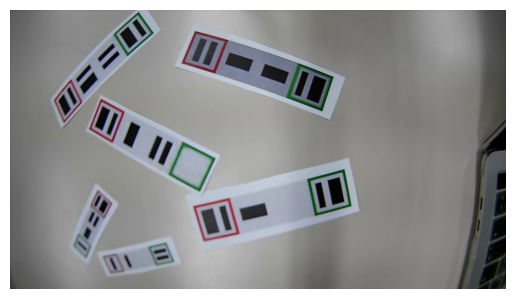

In [422]:
# Load the image
image = cv2.imread("mix_G1_64.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.imshow(image)
plt.axis('off')
plt.show()

In [423]:
# Blur the image
image_blurred = cv2.GaussianBlur(image, (7,7), 0)

In [424]:
# Convert the image to grayscale and hsv
gray_image = cv2.cvtColor(image_blurred, cv2.COLOR_RGB2GRAY)
hsv_image = cv2.cvtColor(image_blurred, cv2.COLOR_RGB2HSV)

In [425]:
# Apply the hsv mask to the image. 

# Best configuration for detecting red squares in the image mix_G1_64.jpg
# H = 120, S = 20, V = 0, H1 = 179, S1 = 255, V1 = 255
lower_red = np.array([120, 20, 0])
upper_red = np.array([179, 255, 255])
mask_red = cv2.inRange(hsv_image, lower_red, upper_red)

# Best configuration for detecting green squares in the image mix_G1_64.jpg
# H = 50, S = 40, V = 0, H1 = 110, S1 = 255, V1 = 160
lower_green = np.array([50, 40, 0])
upper_green = np.array([110, 255, 160])
mask_green = cv2.inRange(hsv_image, lower_green, upper_green)

In [426]:
# Apply close the mask
kernel = np.ones((7,7), np.uint16)   
mask_red_closed = cv2.morphologyEx(mask_red, cv2.MORPH_CLOSE, kernel)
mask_green_closed = cv2.morphologyEx(mask_green, cv2.MORPH_CLOSE, kernel)

# Erode the mask
kernel = np.ones((5,5), np.uint16)
mask_red_eroded = cv2.dilate(mask_red_closed, kernel, iterations=1)
mask_green_eroded = cv2.dilate(mask_green_closed, kernel, iterations=1)

In [427]:
# Aplicar las máscaras a la imagen en escala de grises
segmented_red = cv2.bitwise_and(gray_image, gray_image, mask=mask_red_eroded)
segmented_green = cv2.bitwise_and(gray_image, gray_image, mask=mask_green_eroded)

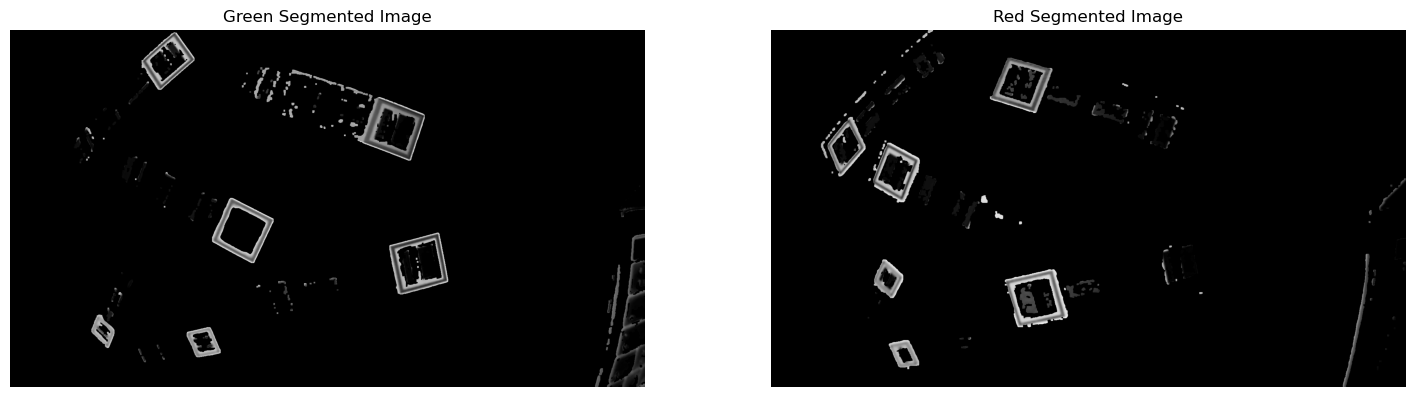

In [428]:
# Display the segmented images
plt.figure(figsize=[18, 5])
plt.subplot(1, 2, 1) ; plt.imshow(segmented_green, cmap='gray') ; plt.title('Green Segmented Image') ; plt.axis('off')
plt.subplot(1, 2, 2) ; plt.imshow(segmented_red, cmap='gray') ; plt.title('Red Segmented Image') ; plt.axis('off')
plt.show()

In [429]:
# Sobel filter the image.
## Apply the Sobel filter to the image. The Sobel filter is used to find the edges in an image.
img_green_sobel_x = cv2.Sobel(segmented_green, cv2.CV_64F, 1, 0, ksize=11) # ksize is the kernel size
img_green_sobel_y = cv2.Sobel(segmented_green, cv2.CV_64F, 0, 1, ksize=11) 
img_green_sobel = np.sqrt(img_green_sobel_x**2 + img_green_sobel_y**2)
img_green_sobel = cv2.normalize(img_green_sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Adaptive threshold the image.
ret, img_green_thresh = cv2.threshold(img_green_sobel, 40, 255, cv2.THRESH_BINARY)

img_red_sobel_x = cv2.Sobel(segmented_red, cv2.CV_64F, 1, 0, ksize=11) # ksize is the kernel size
img_red_sobel_y = cv2.Sobel(segmented_red, cv2.CV_64F, 0, 1, ksize=11)
img_red_sobel = np.sqrt(img_red_sobel_x**2 + img_red_sobel_y**2)
img_red_sobel = cv2.normalize(img_red_sobel, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
# Adaptive threshold the image.
ret, img_red_thresh = cv2.threshold(img_red_sobel, 40, 255, cv2.THRESH_BINARY)

In [430]:
# Find countours in the images
contours_green, hierarchy = cv2.findContours(img_green_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_red, hierarchy = cv2.findContours(img_red_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Number of contours green found =  6
Number of contours red found =  6


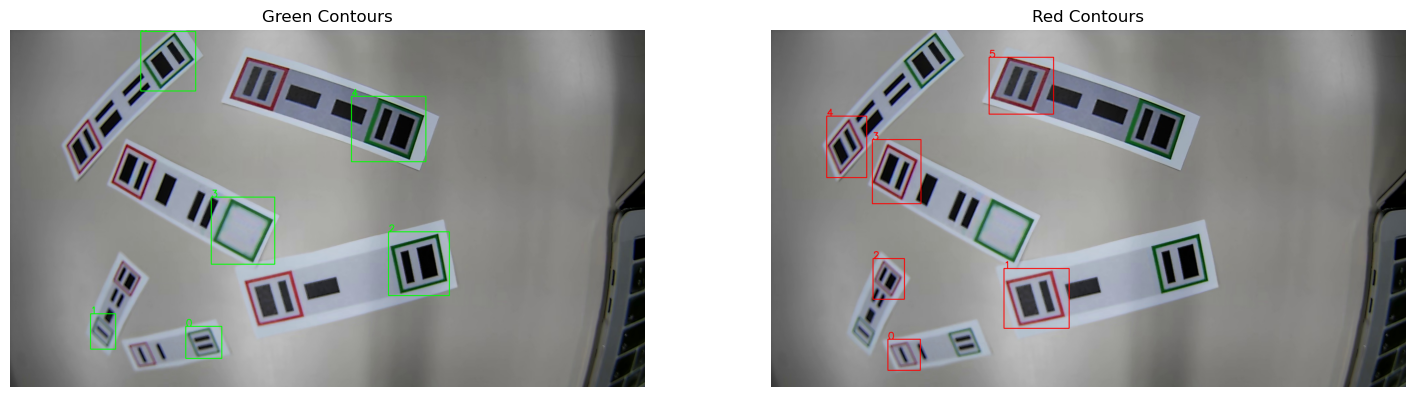

In [431]:
# Filter the contours by aspect ratio and area
filtered_green_contours= []
for contour in contours_green:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    area = cv2.contourArea(contour)
    if area > 2000 and aspect_ratio > 0.6 and aspect_ratio < 1.3:
        filtered_green_contours.append(contour)

filtered_red_contours = []
for contour in contours_red:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    area = cv2.contourArea(contour)
    if area > 4000 and aspect_ratio > 0.6 and aspect_ratio < 1.3:
        filtered_red_contours.append(contour)

# Number of contours
print('Number of contours green found = ', len(filtered_green_contours))
print('Number of contours red found = ', len(filtered_red_contours))

# Draw the contours on the image
contours_green_image = np.copy(image)
contours_red_image = np.copy(image)

index = 0
for contour in filtered_green_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contours_green_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    # Write the index of the contour in the image
    cv2.putText(contours_green_image, str(index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    index += 1

index = 0
for contour in filtered_red_contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(contours_red_image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    # Write the index of the contour in the image
    cv2.putText(contours_red_image, str(index), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
    index += 1

# Display the image with the bounding boxes
plt.figure(figsize=[18, 5])
plt.subplot(1, 2, 1) ; plt.imshow(contours_green_image) ; plt.axis('off'); plt.title('Green Contours') 
plt.subplot(1, 2, 2) ; plt.imshow(contours_red_image) ; plt.axis('off') ; plt.title('Red Contours')
plt.show()

In [432]:
def extract_contour_info(contours):
    contour_info = []

    for contour in contours:
        area = round(cv2.contourArea(contour), 3)
        x, y, w, h = cv2.boundingRect(contour)
        corners = [
            (x, y),
            (x + w, y),
            (x + w, y + h),
            (x, y + h)
        ]
        perimeter = round(cv2.arcLength(contour, True), 3)
        
        contour_info.append({
            'corners': corners,  # Esquinas en relación a la imagen original
            'center': (round(x + w / 2, 3), round(y + h / 2, 3)),
            'width': round(w, 3),
            'height': round(h, 3),
            'area': area,
            'aspect_ratio': round(w / h, 3) if h != 0 else None,
            'perimeter': perimeter,
            'angle': round(cv2.minAreaRect(contour)[-1], 3)
        })

    return contour_info

green_contour_info = extract_contour_info(filtered_green_contours)
red_contour_info = extract_contour_info(filtered_red_contours)

print("Green Contours Info:", green_contour_info)
print("Red Contours Info:", red_contour_info)

Green Contours Info: [{'corners': [(531, 896), (640, 896), (640, 993), (531, 993)], 'center': (585.5, 944.5), 'width': 109, 'height': 97, 'area': 7268.0, 'aspect_ratio': 1.124, 'perimeter': 350.593, 'angle': 66.801}, {'corners': [(243, 858), (319, 858), (319, 965), (243, 965)], 'center': (281.0, 911.5), 'width': 76, 'height': 107, 'area': 4772.0, 'aspect_ratio': 0.71, 'perimeter': 291.706, 'angle': 45.744}, {'corners': [(1144, 610), (1328, 610), (1328, 803), (1144, 803)], 'center': (1236.0, 706.5), 'width': 184, 'height': 193, 'area': 25743.0, 'aspect_ratio': 0.953, 'perimeter': 667.304, 'angle': 75.225}, {'corners': [(608, 505), (800, 505), (800, 708), (608, 708)], 'center': (704.0, 606.5), 'width': 192, 'height': 203, 'area': 23555.0, 'aspect_ratio': 0.946, 'perimeter': 639.553, 'angle': 26.565}, {'corners': [(1032, 200), (1257, 200), (1257, 398), (1032, 398)], 'center': (1144.5, 299.0), 'width': 225, 'height': 198, 'area': 25912.5, 'aspect_ratio': 1.136, 'perimeter': 735.512, 'angle

In [433]:
def match_contours(red_contours_info, green_contours_info):
    matches = []

    for red_contour in red_contours_info:
        best_match = None
        best_angle_match = float('inf')  # Para encontrar el mejor ángulo
        best_score = float('inf')       # Para desempatar usando área y perímetro

        for green_contour in green_contours_info:
            # Calcular distancia entre centros
            center_distance = np.linalg.norm(
                np.array(red_contour['center']) - np.array(green_contour['center'])
            )

            # Descartar si la distancia excede 3.5 veces la anchura del contorno rojo
            if center_distance > 3.2 * red_contour['width']:
                continue

            # Calcular diferencia de ángulo
            angle_diff = abs(red_contour['angle'] - green_contour['angle'])

            # Descartar si la diferencia de ángulo es mayor a 10 grados
            if angle_diff > 20:
                continue

            # Calcular diferencias adicionales para desempatar
            area_diff = abs(red_contour['area'] - green_contour['area'])
            perimeter_diff = abs(red_contour['perimeter'] - green_contour['perimeter'])

            # Crear puntaje de desempate
            score = area_diff + perimeter_diff

            # Actualizar el mejor match
            if angle_diff < best_angle_match or (angle_diff == best_angle_match and score < best_score):
                best_angle_match = angle_diff
                best_score = score
                best_match = green_contour

        if best_match:
            matches.append((red_contour, best_match))

    return matches

# Emparejar los contornos
matched_contours = match_contours(red_contour_info, green_contour_info)

# Mostrar los emparejamientos
for red, green in matched_contours:
    print(f"Red contour {red['center']} matched with Green contour {green['center']}")


Red contour (402.0, 982.0) matched with Green contour (585.5, 944.5)
Red contour (802.5, 811.5) matched with Green contour (1236.0, 706.5)
Red contour (355.5, 752.5) matched with Green contour (281.0, 911.5)
Red contour (379.5, 428.0) matched with Green contour (704.0, 606.5)
Red contour (228.5, 353.0) matched with Green contour (478.0, 94.0)
Red contour (756.5, 168.0) matched with Green contour (1144.5, 299.0)


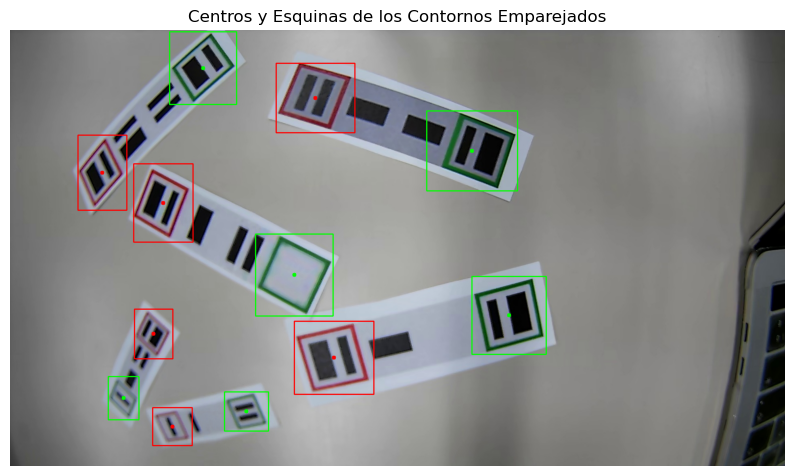

In [434]:
# Crear una copia de la imagen original para dibujar los contornos emparejados
image_with_centers_and_corners = np.copy(image)

# Dibujar los contornos emparejados
for red_contour, green_contour in matched_contours:
    # Dibujar el centro del contorno rojo
    cv2.circle(image_with_centers_and_corners, (int(red_contour['center'][0]), int(red_contour['center'][1])), 5, (255, 0, 0), -1)
    # Dibujar las esquinas del contorno rojo
    for i in range(4):
        cv2.line(image_with_centers_and_corners, tuple(red_contour['corners'][i]), tuple(red_contour['corners'][(i + 1) % 4]), (255, 0, 0), 2)

    # Dibujar el centro del contorno verde
    cv2.circle(image_with_centers_and_corners, (int(green_contour['center'][0]), int(green_contour['center'][1])), 5, (0, 255, 0), -1)
    # Dibujar las esquinas del contorno verde
    for i in range(4):
        cv2.line(image_with_centers_and_corners, tuple(green_contour['corners'][i]), tuple(green_contour['corners'][(i + 1) % 4]), (0, 255, 0), 2)

# Mostrar la imagen con los centros y esquinas dibujados
plt.figure(figsize=[10, 10])
plt.imshow(image_with_centers_and_corners)
plt.axis('off')
plt.title('Centros y Esquinas de los Contornos Emparejados')
plt.show()

In [456]:
def cut_bounding_box(matched_contours):
    extracted_images = []

    for red_contour, green_contour in matched_contours:
        # Obtener los puntos de los contornos
        red_points = np.array(red_contour['corners'])
        green_points = np.array(green_contour['corners'])

        # Combinar los puntos de ambos contornos
        all_points = np.vstack((red_points, green_points))

        # Calcular la bounding box que contenga todos los puntos
        x_min, y_min = np.min(all_points, axis=0)
        x_max, y_max = np.max(all_points, axis=0)

        # Recortar la imagen original usando la bounding box
        
        extracted_image = image[y_min:y_max, x_min:x_max]

        # Rotar la imagen para que el contorno rojo quede horizontal y a la izquierda
        # Comparar las coordenadas de los centros para determinar la rotación necesaria
        # print(f"Red center: {red_contour['center']}, Green center: {green_contour['center']}")
        if red_contour['center'][0] > green_contour['center'][0]:
            if red_contour['center'][1] < green_contour['center'][1]:
                extracted_image = cv2.rotate(extracted_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            else:
                extracted_image = cv2.rotate(extracted_image, cv2.ROTATE_180)
        elif red_contour['center'][1] > green_contour['center'][1]:
            extracted_image = cv2.rotate(extracted_image, cv2.ROTATE_90_CLOCKWISE)

        # Print the size of the extracted image
        # print(f"Extracted image size: {extracted_image.shape}")

        if (extracted_image.shape[0] > extracted_image.shape[1]):
            extracted_image = cv2.rotate(extracted_image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        # Print the corners of the contours in the extracted image
        # print(f"Red corners: {red_points.tolist()}, Green corners: {green_points.tolist()}")
        # print(f"Red corners in extracted image: {(red_points - np.array([x_min, y_min])).tolist()}")

        # Guardar la imagen recortada y rotada
        extracted_images.append(extracted_image)
    
    return extracted_images


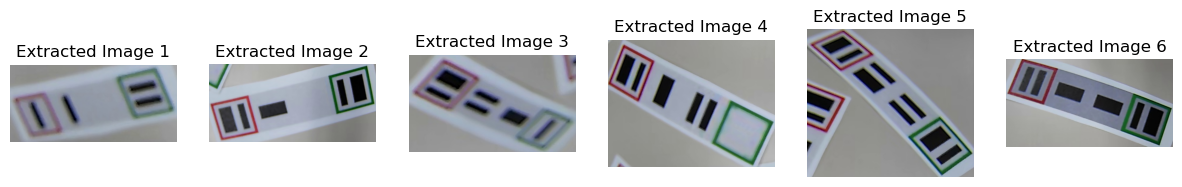

In [457]:
extracted_images = cut_bounding_box(matched_contours)

plt.figure(figsize=[15, 10])
for i, img in enumerate(extracted_images):
    plt.subplot(1, len(extracted_images), i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Extracted Image {i+1}')
plt.show()